<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

Э
В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List, Tuple, Dict

import seaborn as sns
sns.set_style('dark')

c:\Users\knyze\miniforge3\envs\main_nn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\knyze\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [4]:
# Загрузим датасет
dataset = load_dataset('imdb')

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [6]:
sentences = []
word_threshold = 32

for text in tqdm(dataset['train']['text']):
    text_sents = sent_tokenize(text)
    sentences.extend([i.lower() for i in text_sents if len(word_tokenize(i)) < word_threshold])

100%|██████████| 25000/25000 [00:24<00:00, 1028.26it/s]


In [7]:
print("Всего предложений:", len(sentences))

Всего предложений: 198801


Посчитаем для каждого слова его встречаемость.

In [8]:
sentences

['i rented i am curious-yellow from my video store because of all the controversy that surrounded it when it was first released in 1967.',
 "really, the sex and nudity scenes are few and far between, even then it's not shot like some cheaply made porno.",
 'while my countrymen mind find it shocking, in reality sex and nudity are a major staple in swedish cinema.',
 'i am curious-yellow is a good film for anyone wanting to study the meat and potatoes (no pun intended) of swedish cinema.',
 "but really, this film doesn't have much of a plot.",
 '"i am curious: yellow" is a risible and pretentious steaming pile.',
 "it doesn't matter what one's political views are because this film can hardly be taken seriously on any level.",
 "as for the claim that frontal male nudity is an automatic nc-17, that isn't true.",
 "i've seen r-rated films with male nudity.",
 'granted, they only offer some fleeting views, but where are the r-rated films with gaping vulvas and flapping labia?',
 "nowhere, be

In [9]:
words = Counter()

for sentence in tqdm(sentences):
    for word in word_tokenize(sentence):
        words[word] += 1

100%|██████████| 198801/198801 [00:12<00:00, 15824.35it/s]


Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [10]:
len(words)

68415

In [11]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

for word, count in words.most_common(vocab_size):
    vocab.add(word)

vocab_size = len(vocab) - 4

In [12]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [13]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [14]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [15]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in word_tokenize(self.data[idx])]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [16]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [17]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2, random_state=1)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5, random_state=1)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)
eval_dataloader = DataLoader(eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [18]:
def evaluate(model, criterion):
    model.eval()
    losses = []
    perplexities = []

    with torch.no_grad():
        for batch in test_dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexities.append(torch.exp(loss).item())
            losses.append(loss.item())

    perplexity = sum(perplexities) / len(perplexities)
    loss = sum(losses) / len(losses)

    return perplexity, loss

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [19]:
def train(model, criterion, optimizer, epochs=10, scheduler=None):

    train_losses = []
    eval_losses = []
    train_perplexities = []
    eval_perplexities = []

    for epoch in range(epochs):
        model.train()
        losses = []
        perplexities = []

        for batch in tqdm(train_dataloader, desc=f'Epoch {epoch}'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            perplexities.append(torch.exp(loss).item())

        train_losses.append(np.mean(losses))
        train_perplexities.append(np.mean(perplexities))

        val_perplexity, val_loss = evaluate(model, criterion)
        eval_losses.append(val_loss)
        eval_perplexities.append(val_perplexity)

        print('val_loss:', val_loss, 'val_perplexity:', val_perplexity)

        if scheduler != None:
            scheduler.step(val_loss)
        
    result = {
        'train_losses': train_losses,
        'train_perplexities': train_perplexities,
        'eval_losses': eval_losses,
        'eval_perplexities': eval_perplexities
    }

    return result

In [20]:
def plot_results(results):
    train_loss = results['train_losses']
    train_perplexity = results['train_perplexities']
    eval_loss = results['eval_losses']
    eval_perplexity = results['eval_perplexities']

    x = np.arange(len(train_loss))

    print("min train loss:", min(train_loss), 'min train perplexity:', min(train_perplexity))

    plt.figure(figsize=(16, 9))
    plt.plot(x, train_loss, label='train_loss')
    plt.plot(x, eval_loss, label='eval_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

    print('min eval loss:', min(eval_loss), 'min eval perplexity:', min(eval_perplexity))

    plt.figure(figsize=(16, 9))
    plt.plot(x, train_perplexity, label='train_perplexity')
    plt.plot(x, eval_perplexity, label='eval_perplexity')
    plt.xlabel('epoch')
    plt.ylabel('pexplexity')
    plt.title('Peplexity')
    plt.legend()
    plt.show()

In [64]:
def generate_sequence(model, starting_seq: str, max_num_words: int = 30) -> str:
    input_ids = [word2ind['<bos>']] + [word2ind.get(word, word2ind['<unk>']) for word in starting_seq.split()]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_num_words):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break
    words = ''.join([ind2word[idx.item()] + ' ' for idx in input_ids])

    return words

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

In [23]:
class Model1(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size=len(vocab)):
        super(Model1, self).__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, vocab_size)

        self.dropout = nn.Dropout(0.1)
        self.non_lin = nn.Tanh()

    def forward(self, input_batch):
        x = self.embedding(input_batch)
        output, _ = self.rnn(x)

        output = self.dropout(self.non_lin(self.linear1(output)))

        result = self.linear2(output)

        return result

In [24]:
model = Model1(hidden_dim=256).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.AdamW(model.parameters())

In [25]:
result = train(model, criterion, optimizer, epochs=10)

Epoch 0: 100%|██████████| 1243/1243 [01:09<00:00, 17.95it/s]


val_loss: 4.931304622919131 val_perplexity: 139.17927717551206


Epoch 1: 100%|██████████| 1243/1243 [01:16<00:00, 16.28it/s]


val_loss: 4.778143888864761 val_perplexity: 119.45387351207243


Epoch 2: 100%|██████████| 1243/1243 [01:18<00:00, 15.84it/s]


val_loss: 4.717450520931146 val_perplexity: 112.4387917151818


Epoch 3: 100%|██████████| 1243/1243 [01:14<00:00, 16.72it/s]


val_loss: 4.703827576759534 val_perplexity: 110.94563743395683


Epoch 4: 100%|██████████| 1243/1243 [01:17<00:00, 16.12it/s]


val_loss: 4.701173009016575 val_perplexity: 110.67212016765887


Epoch 5: 100%|██████████| 1243/1243 [01:09<00:00, 17.99it/s]


val_loss: 4.720585306485494 val_perplexity: 112.87487646249625


Epoch 6: 100%|██████████| 1243/1243 [01:08<00:00, 18.20it/s]


val_loss: 4.724154359255081 val_perplexity: 113.29754335452348


Epoch 7: 100%|██████████| 1243/1243 [01:08<00:00, 18.22it/s]


val_loss: 4.730096535804944 val_perplexity: 113.97636296198918


Epoch 8: 100%|██████████| 1243/1243 [01:08<00:00, 18.18it/s]


val_loss: 4.749931989571987 val_perplexity: 116.29913207812187


Epoch 9: 100%|██████████| 1243/1243 [01:08<00:00, 18.18it/s]


val_loss: 4.775478916290479 val_perplexity: 119.33351634098933


min train loss: 4.028855519053059 min train perplexity: 56.37445043807824


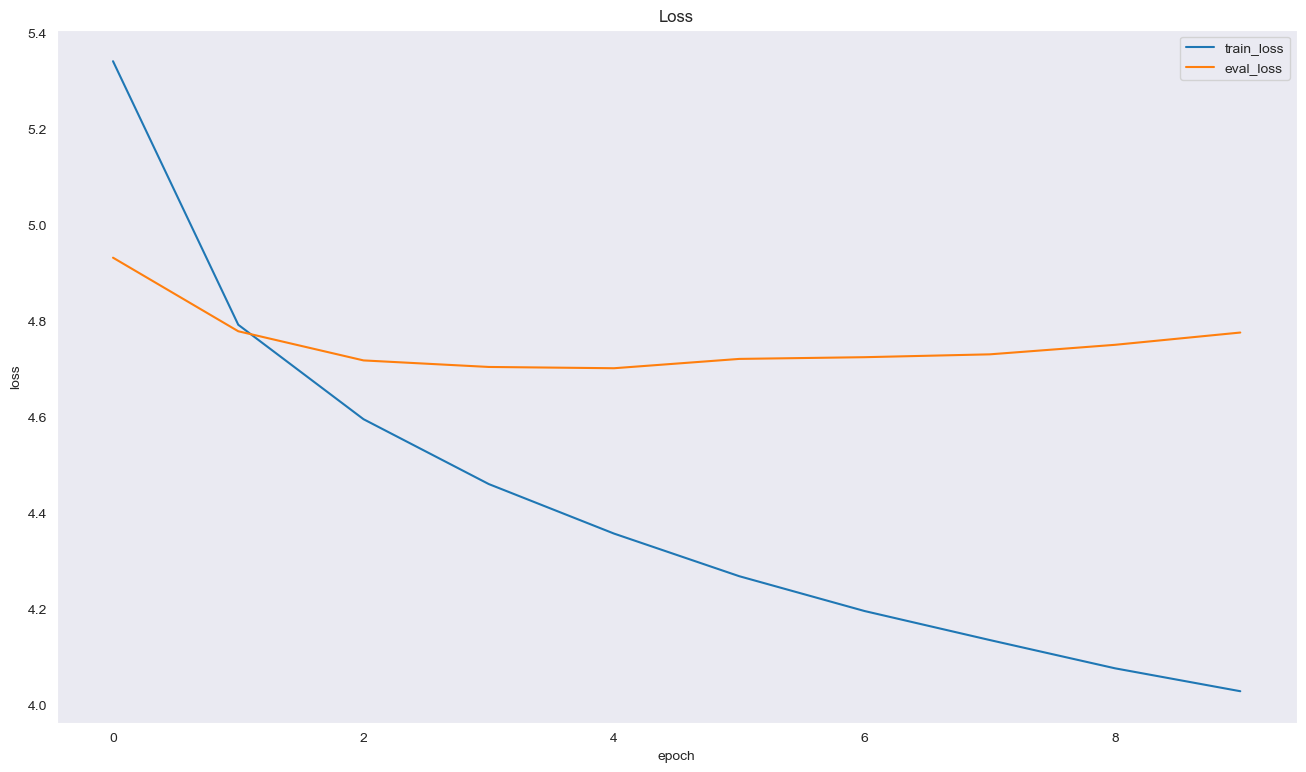

min eval loss: 4.701173009016575 min eval perplexity: 110.67212016765887


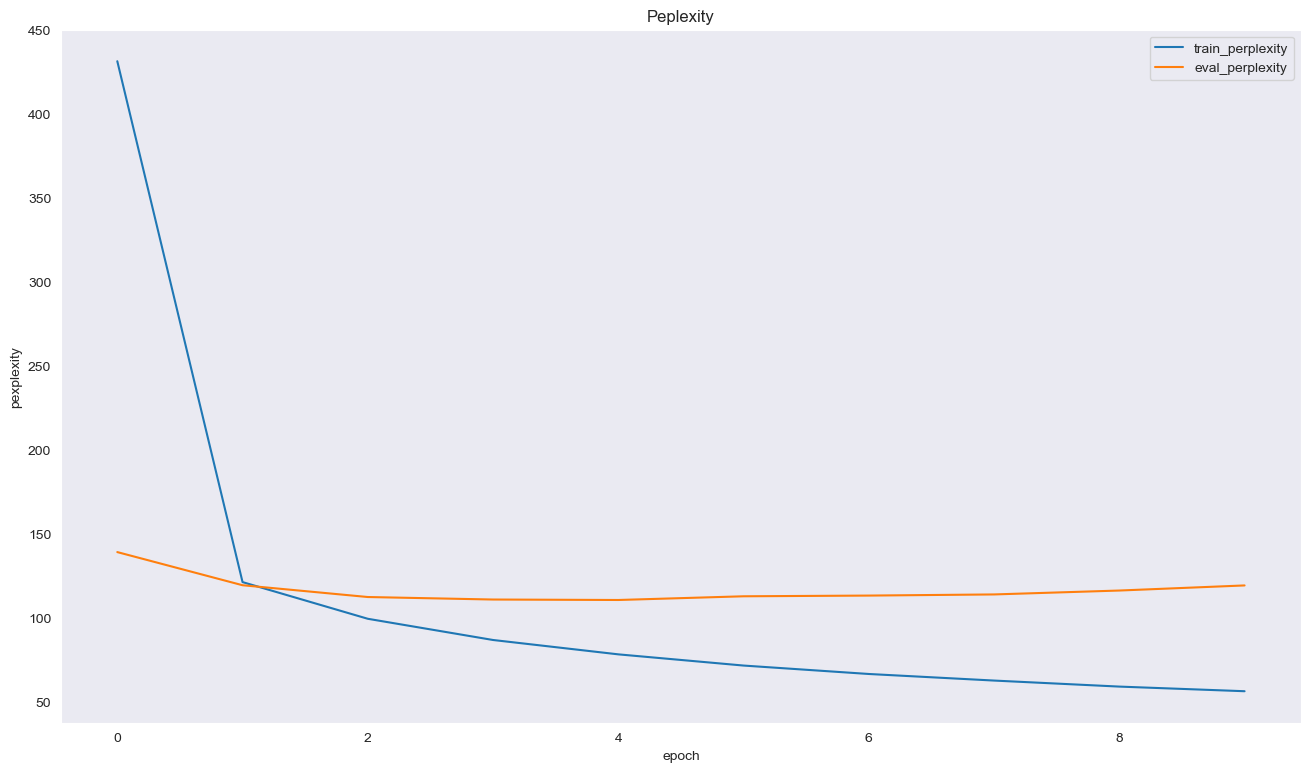

In [26]:
plot_results(result)

In [27]:
model = Model1(hidden_dim=256).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [28]:
result = train(model, criterion, optimizer, epochs=10)

Epoch 0: 100%|██████████| 1243/1243 [01:07<00:00, 18.49it/s]


val_loss: 4.946363549966079 val_perplexity: 141.28037785261105


Epoch 1: 100%|██████████| 1243/1243 [01:07<00:00, 18.49it/s]


val_loss: 4.785403792674725 val_perplexity: 120.29933567536183


Epoch 2: 100%|██████████| 1243/1243 [01:07<00:00, 18.46it/s]


val_loss: 4.731471465184138 val_perplexity: 114.00591825827574


Epoch 3: 100%|██████████| 1243/1243 [01:07<00:00, 18.44it/s]


val_loss: 4.706811428070068 val_perplexity: 111.25286449530186


Epoch 4: 100%|██████████| 1243/1243 [01:07<00:00, 18.47it/s]


val_loss: 4.70770713304862 val_perplexity: 111.37899917211288


Epoch 5: 100%|██████████| 1243/1243 [01:07<00:00, 18.48it/s]


val_loss: 4.71516791673807 val_perplexity: 112.241792287582


Epoch 6: 100%|██████████| 1243/1243 [01:07<00:00, 18.43it/s]


val_loss: 4.73679966498644 val_perplexity: 114.73189461536897


Epoch 7: 100%|██████████| 1243/1243 [01:07<00:00, 18.50it/s]


val_loss: 4.760006360518626 val_perplexity: 117.44516710134653


Epoch 8: 100%|██████████| 1243/1243 [01:07<00:00, 18.50it/s]


val_loss: 4.77549238388355 val_perplexity: 119.30991133665427


Epoch 9: 100%|██████████| 1243/1243 [01:07<00:00, 18.49it/s]


val_loss: 4.803712569750273 val_perplexity: 122.74472065460988


min train loss: 4.028436271586154 min train perplexity: 56.34690484363804


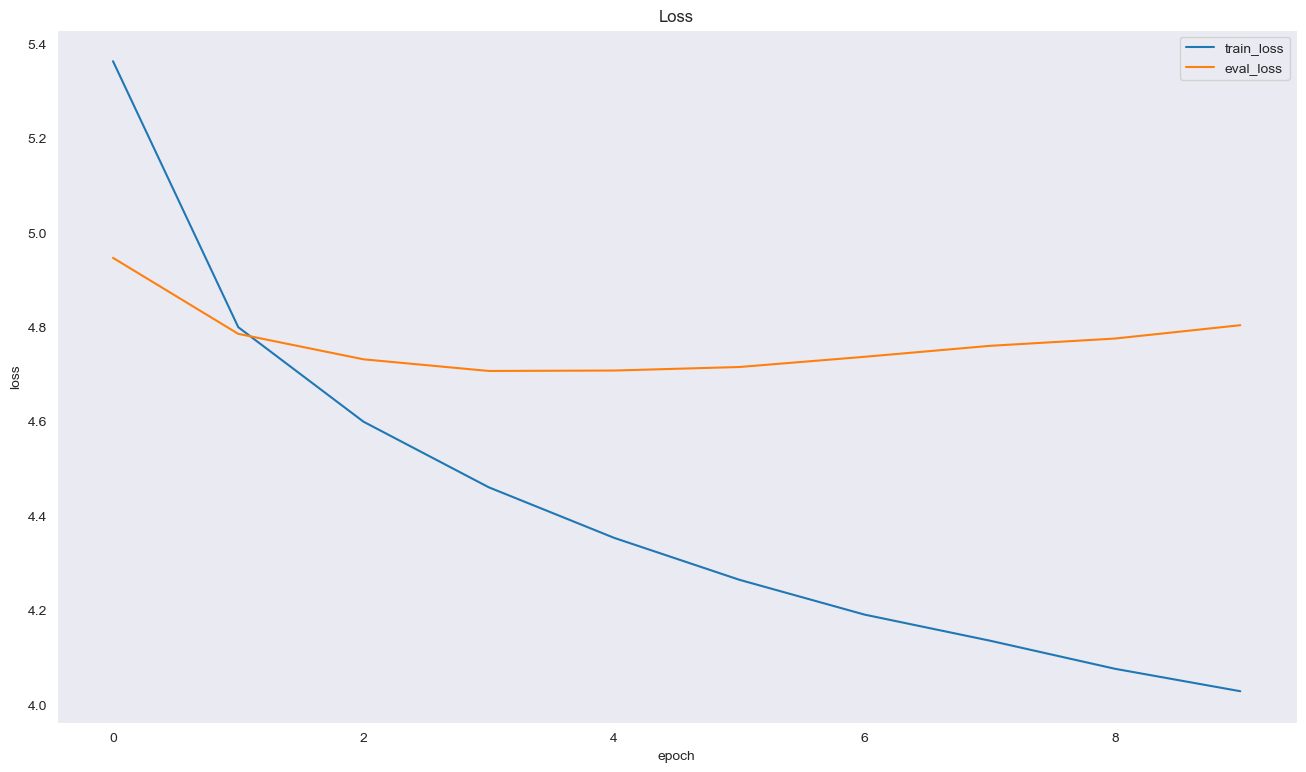

min eval loss: 4.706811428070068 min eval perplexity: 111.25286449530186


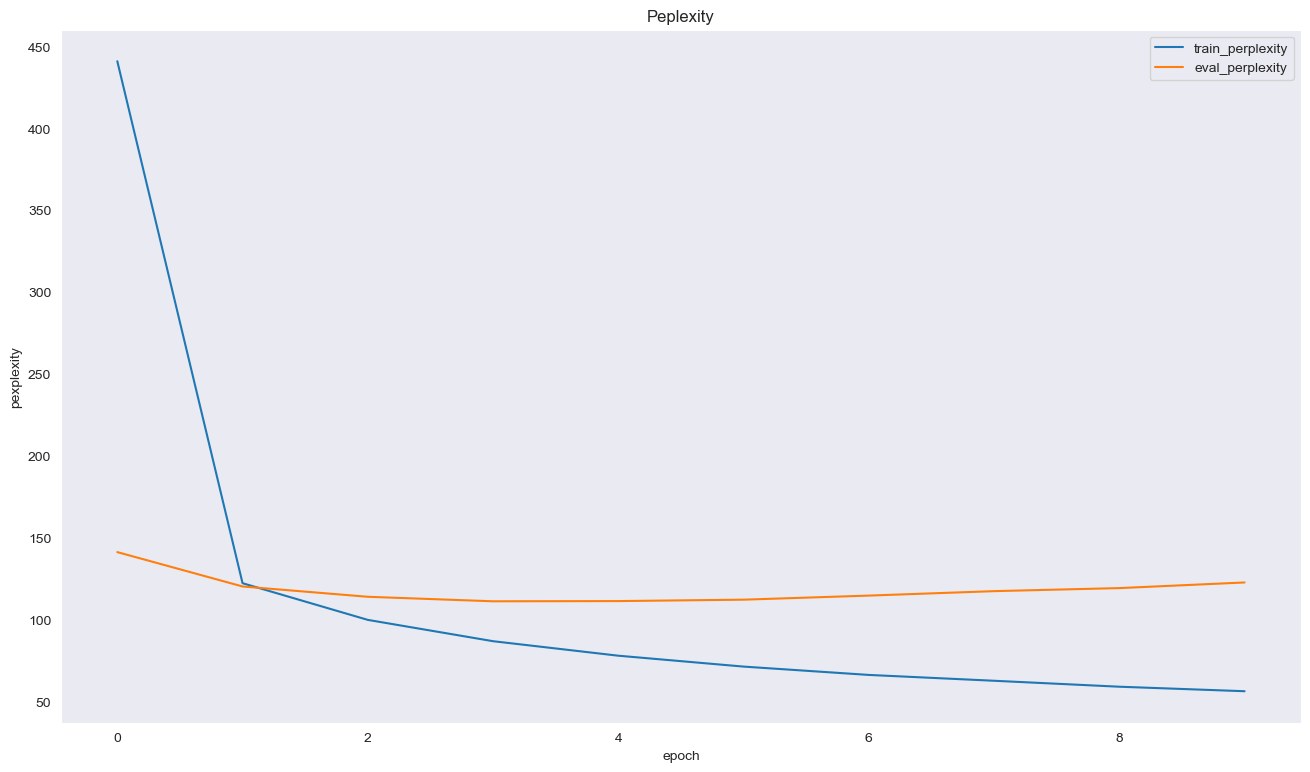

In [29]:
plot_results(result)

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [30]:
class Model2(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size=len(vocab)):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, vocab_size)

        self.dropout = nn.Dropout(0.1)
        self.non_lin = nn.Tanh()

    def forward(self, input_batch):
        x = self.embedding(input_batch)
        output, _ = self.rnn(x)

        output = self.dropout(self.non_lin(self.linear1(output)))

        result = self.linear2(output)

        return result

In [31]:
model = Model2(hidden_dim=256).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.AdamW(model.parameters())

In [32]:
result = train(model=model, criterion=criterion, optimizer=optimizer)

Epoch 0: 100%|██████████| 1243/1243 [01:09<00:00, 17.95it/s]


val_loss: 4.901153154862233 val_perplexity: 135.0547586587759


Epoch 1: 100%|██████████| 1243/1243 [01:09<00:00, 17.96it/s]


val_loss: 4.717668625024649 val_perplexity: 112.44032717973758


Epoch 2: 100%|██████████| 1243/1243 [01:09<00:00, 17.96it/s]


val_loss: 4.651658146809309 val_perplexity: 105.27547190739558


Epoch 3: 100%|██████████| 1243/1243 [01:09<00:00, 17.95it/s]


val_loss: 4.630200841487983 val_perplexity: 103.05968597607735


Epoch 4: 100%|██████████| 1243/1243 [01:09<00:00, 17.95it/s]


val_loss: 4.625870548761808 val_perplexity: 102.63508023971167


Epoch 5: 100%|██████████| 1243/1243 [01:09<00:00, 17.94it/s]


val_loss: 4.635889111421047 val_perplexity: 103.6903001345121


Epoch 6: 100%|██████████| 1243/1243 [01:10<00:00, 17.68it/s]


val_loss: 4.652101366947859 val_perplexity: 105.40909742697691


Epoch 7: 100%|██████████| 1243/1243 [01:09<00:00, 17.86it/s]


val_loss: 4.67232835598481 val_perplexity: 107.59716459421011


Epoch 8: 100%|██████████| 1243/1243 [01:09<00:00, 17.92it/s]


val_loss: 4.694822140229054 val_perplexity: 110.06506313421788


Epoch 9: 100%|██████████| 1243/1243 [01:09<00:00, 17.96it/s]


val_loss: 4.718091007990715 val_perplexity: 112.68858469449557


min train loss: 3.8785714360848607 min train perplexity: 48.5078813548253


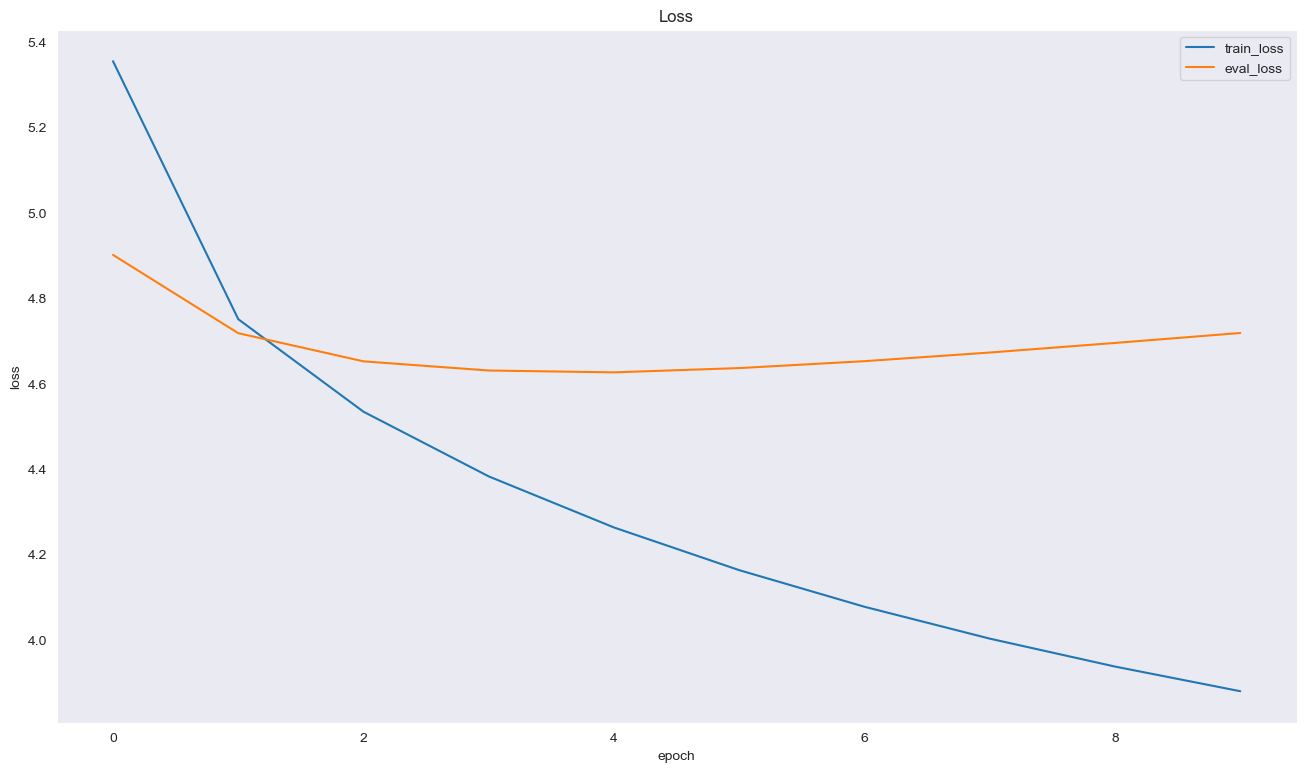

min eval loss: 4.625870548761808 min eval perplexity: 102.63508023971167


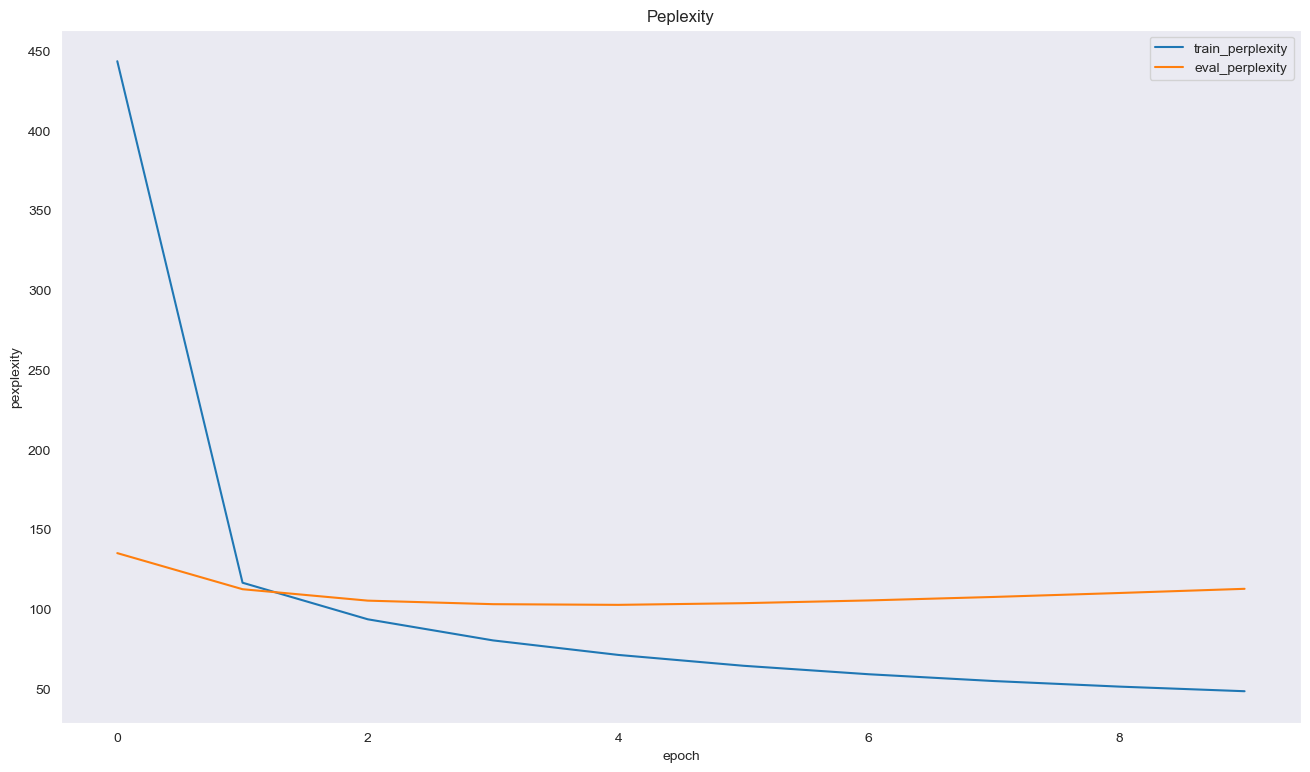

In [33]:
plot_results(result)

### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

In [34]:
class Model3(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size=len(vocab)):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, vocab_size)

        self.dropout = nn.Dropout(0.1)
        self.non_lin = nn.Tanh()

    def forward(self, input_batch):
        x = self.embedding(input_batch)
        output, _ = self.rnn(x)

        output = self.dropout(self.non_lin(self.linear1(output)))

        result = self.linear2(output)

        return result

In [35]:
model = Model3(hidden_dim=256).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.AdamW(model.parameters())

In [36]:
result = train(model=model, criterion=criterion, optimizer=optimizer)

Epoch 0: 100%|██████████| 1243/1243 [01:09<00:00, 17.92it/s]


val_loss: 4.924435315988003 val_perplexity: 138.2389499468681


Epoch 1: 100%|██████████| 1243/1243 [01:09<00:00, 17.91it/s]


val_loss: 4.720397857519297 val_perplexity: 112.75104566720816


Epoch 2: 100%|██████████| 1243/1243 [01:09<00:00, 17.91it/s]


val_loss: 4.637159585952759 val_perplexity: 103.76142858847594


Epoch 3: 100%|██████████| 1243/1243 [01:09<00:00, 17.87it/s]


val_loss: 4.600478887557983 val_perplexity: 100.0409099383232


Epoch 4: 100%|██████████| 1243/1243 [01:11<00:00, 17.47it/s]


val_loss: 4.5885551159198465 val_perplexity: 98.87443640293219


Epoch 5: 100%|██████████| 1243/1243 [01:09<00:00, 17.87it/s]


val_loss: 4.590706886389317 val_perplexity: 99.10291828253331


Epoch 6: 100%|██████████| 1243/1243 [01:09<00:00, 17.88it/s]


val_loss: 4.600069058247102 val_perplexity: 100.06242864559859


Epoch 7: 100%|██████████| 1243/1243 [01:09<00:00, 17.89it/s]


val_loss: 4.614932240583958 val_perplexity: 101.58332453018579


Epoch 8: 100%|██████████| 1243/1243 [01:09<00:00, 17.86it/s]


val_loss: 4.633114374600924 val_perplexity: 103.4716682434082


Epoch 9: 100%|██████████| 1243/1243 [01:09<00:00, 17.79it/s]


val_loss: 4.652865972274389 val_perplexity: 105.55121671236478


min train loss: 3.849450204224713 min train perplexity: 47.11863869615648


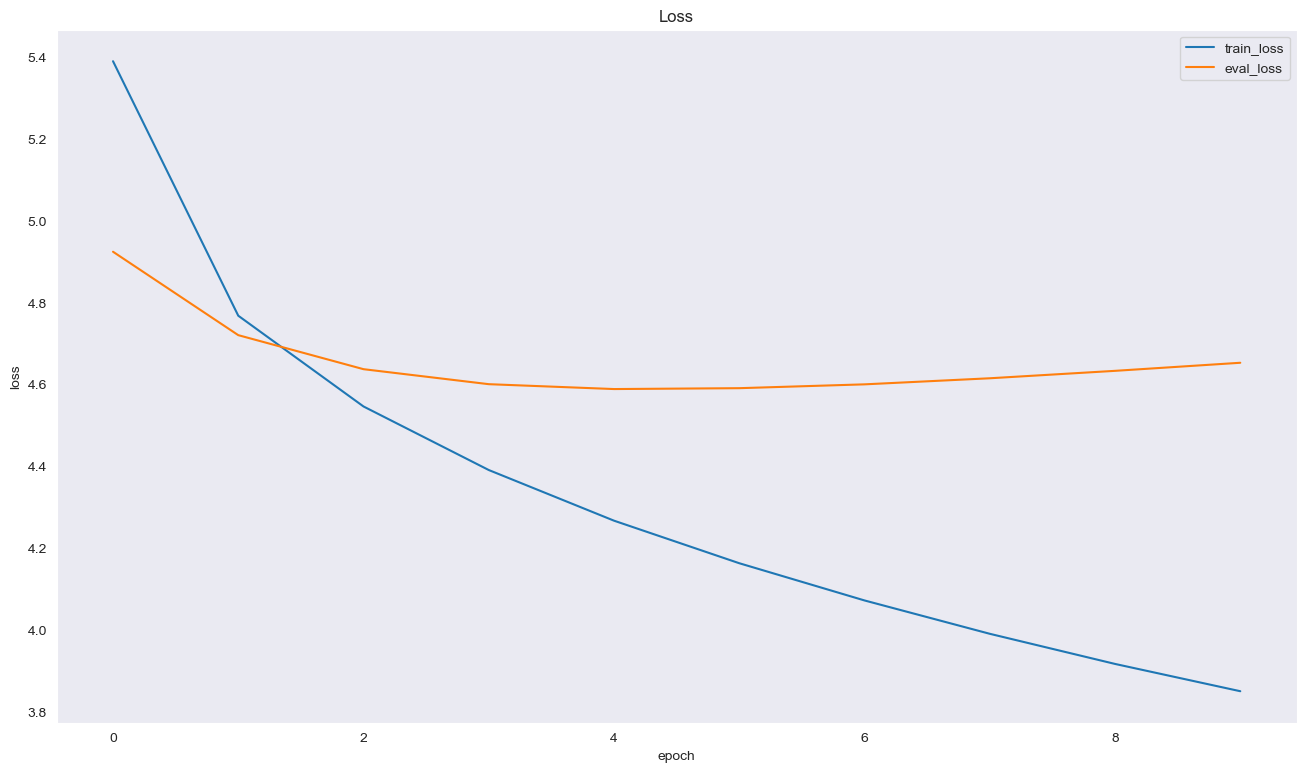

min eval loss: 4.5885551159198465 min eval perplexity: 98.87443640293219


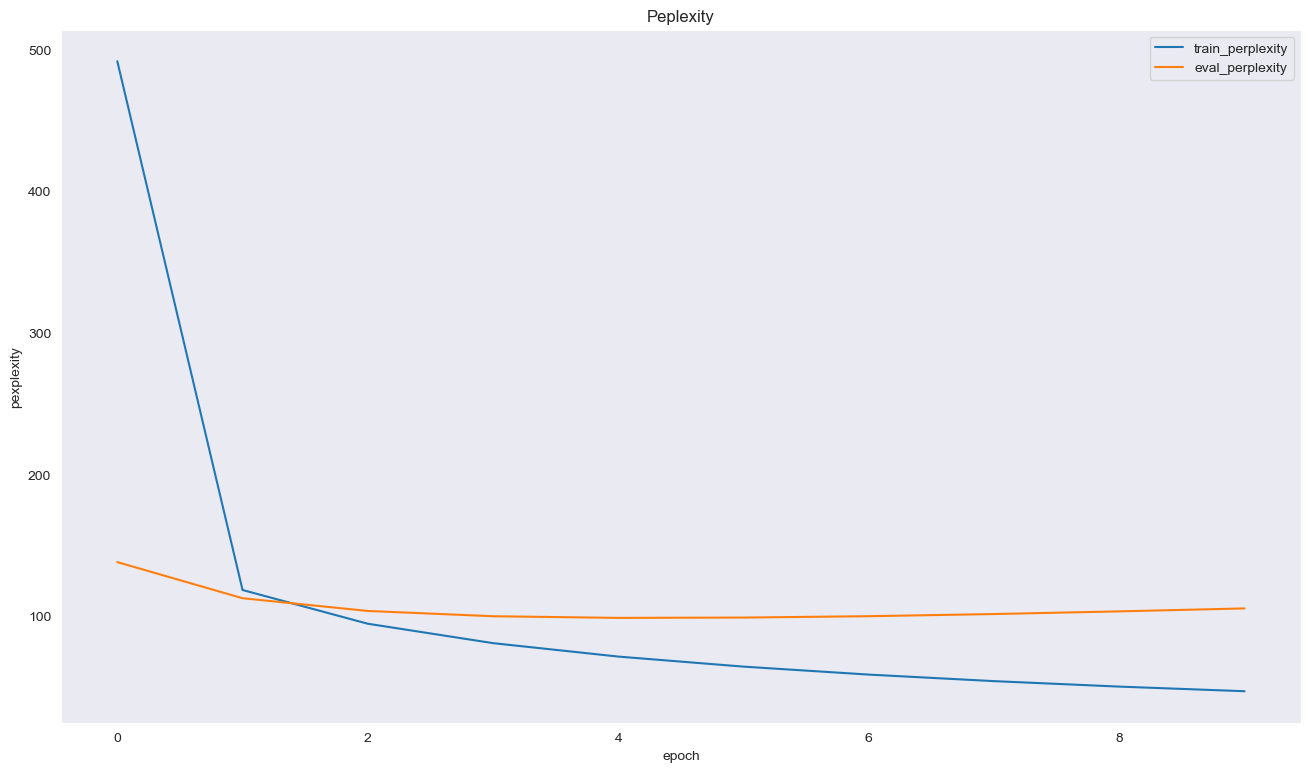

In [39]:
plot_results(result)

In [40]:
model = Model3(hidden_dim=256).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

c:\Users\knyze\miniforge3\envs\main_nn\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [41]:
result = train(model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler)

Epoch 0: 100%|██████████| 1243/1243 [01:09<00:00, 17.80it/s]


val_loss: 4.911983156815554 val_perplexity: 136.51106237753842


Epoch 1: 100%|██████████| 1243/1243 [01:09<00:00, 17.86it/s]


val_loss: 4.715091362977639 val_perplexity: 112.14410732953976


Epoch 2: 100%|██████████| 1243/1243 [01:09<00:00, 17.84it/s]


val_loss: 4.635663020305144 val_perplexity: 103.59866523742676


Epoch 3: 100%|██████████| 1243/1243 [01:09<00:00, 17.76it/s]


val_loss: 4.602500093288911 val_perplexity: 100.24183576534956


Epoch 4: 100%|██████████| 1243/1243 [01:10<00:00, 17.65it/s]


val_loss: 4.593382541949932 val_perplexity: 99.34930356343587


Epoch 5: 100%|██████████| 1243/1243 [01:10<00:00, 17.62it/s]


val_loss: 4.596699907229497 val_perplexity: 99.70031078045184


Epoch 6: 100%|██████████| 1243/1243 [01:10<00:00, 17.69it/s]


val_loss: 4.609036824642083 val_perplexity: 100.96516467363406


Epoch 7: 100%|██████████| 1243/1243 [01:11<00:00, 17.39it/s]


val_loss: 4.625732486064617 val_perplexity: 102.69066443810097


Epoch 8: 100%|██████████| 1243/1243 [01:10<00:00, 17.65it/s]


val_loss: 4.616652870789553 val_perplexity: 101.78369086827988


Epoch 9: 100%|██████████| 1243/1243 [01:19<00:00, 15.56it/s]


val_loss: 4.625645249317854 val_perplexity: 102.71657469333746


min train loss: 3.813550973456422 min train perplexity: 45.47477273488371


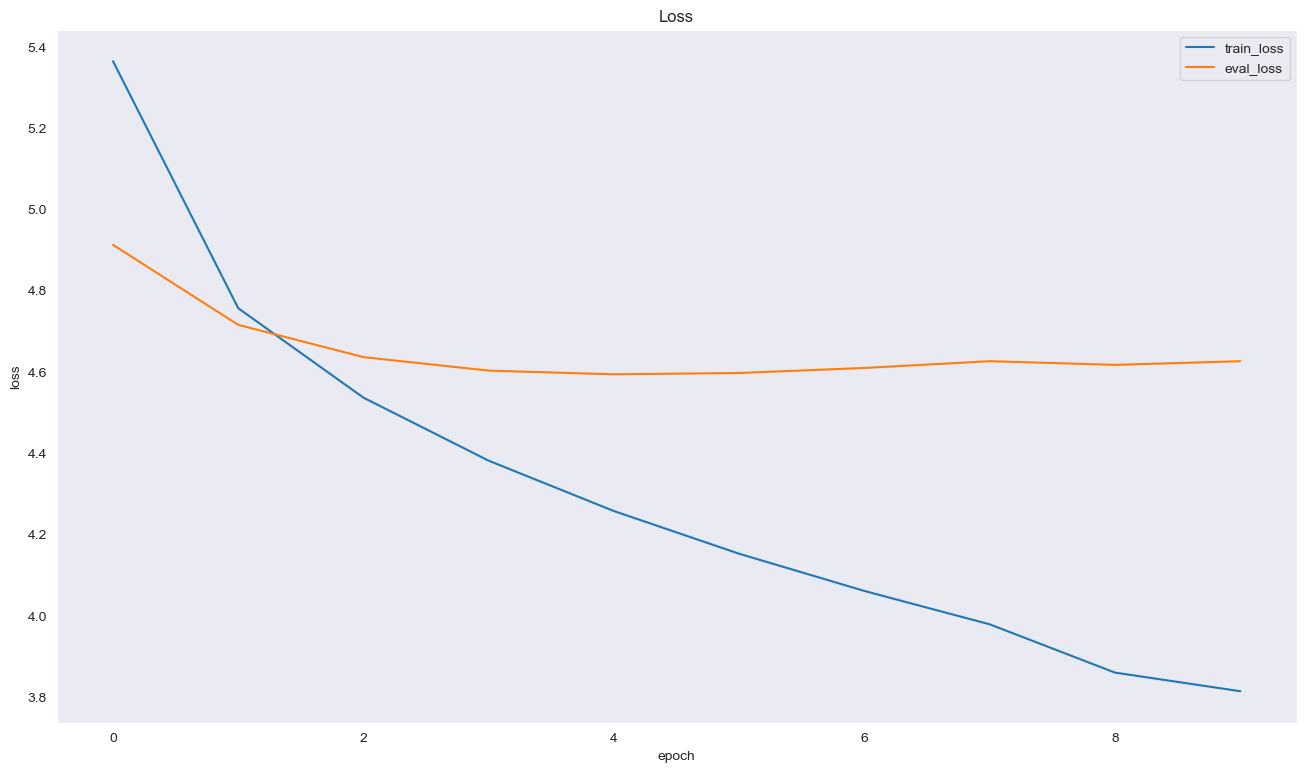

min eval loss: 4.593382541949932 min eval perplexity: 99.34930356343587


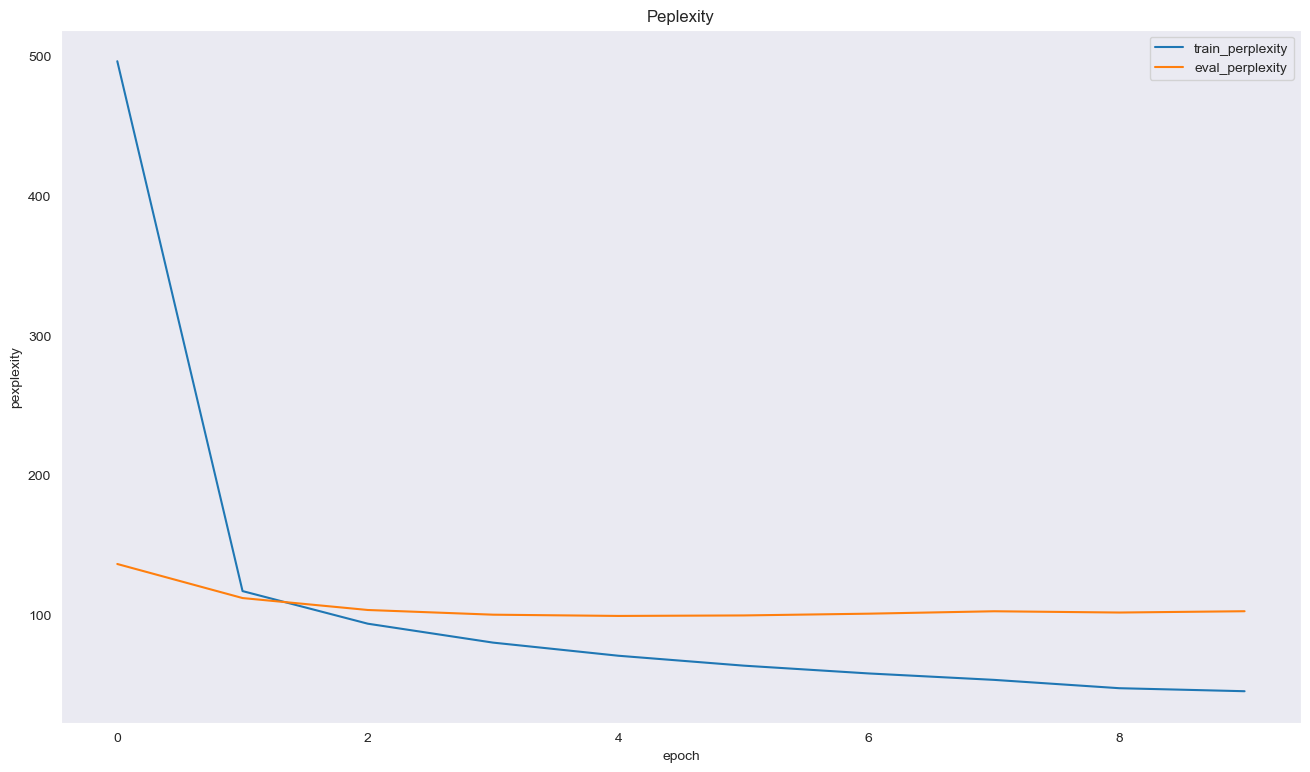

In [43]:
plot_results(result)

In [44]:
model = Model3(hidden_dim=256).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=1, verbose=True
)

c:\Users\knyze\miniforge3\envs\main_nn\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [45]:
result = train(model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler)

Epoch 0: 100%|██████████| 1243/1243 [01:16<00:00, 16.26it/s]


val_loss: 4.903200763922471 val_perplexity: 135.32973490005884


Epoch 1: 100%|██████████| 1243/1243 [01:12<00:00, 17.15it/s]


val_loss: 4.710564986253396 val_perplexity: 111.62960037818321


Epoch 2: 100%|██████████| 1243/1243 [01:09<00:00, 17.79it/s]


val_loss: 4.632079686873999 val_perplexity: 103.21640826494266


Epoch 3: 100%|██████████| 1243/1243 [01:22<00:00, 15.07it/s]


val_loss: 4.599750787783892 val_perplexity: 99.94522373492902


Epoch 4: 100%|██████████| 1243/1243 [01:23<00:00, 14.93it/s]


val_loss: 4.5904801319807005 val_perplexity: 99.04459713666867


Epoch 5: 100%|██████████| 1243/1243 [01:12<00:00, 17.04it/s]


val_loss: 4.594462199088855 val_perplexity: 99.46136367015349


Epoch 6: 100%|██████████| 1243/1243 [01:11<00:00, 17.41it/s]


val_loss: 4.606403787930806 val_perplexity: 100.67707712222368


Epoch 7: 100%|██████████| 1243/1243 [01:11<00:00, 17.44it/s]


val_loss: 4.598493080872756 val_perplexity: 99.90991856501653


Epoch 8: 100%|██████████| 1243/1243 [01:11<00:00, 17.43it/s]


val_loss: 4.6072248464975605 val_perplexity: 100.79785987658379


Epoch 9: 100%|██████████| 1243/1243 [01:11<00:00, 17.45it/s]


val_loss: 4.598062683374454 val_perplexity: 99.88748080913837


min train loss: 3.8118025926649812 min train perplexity: 45.422300423141074


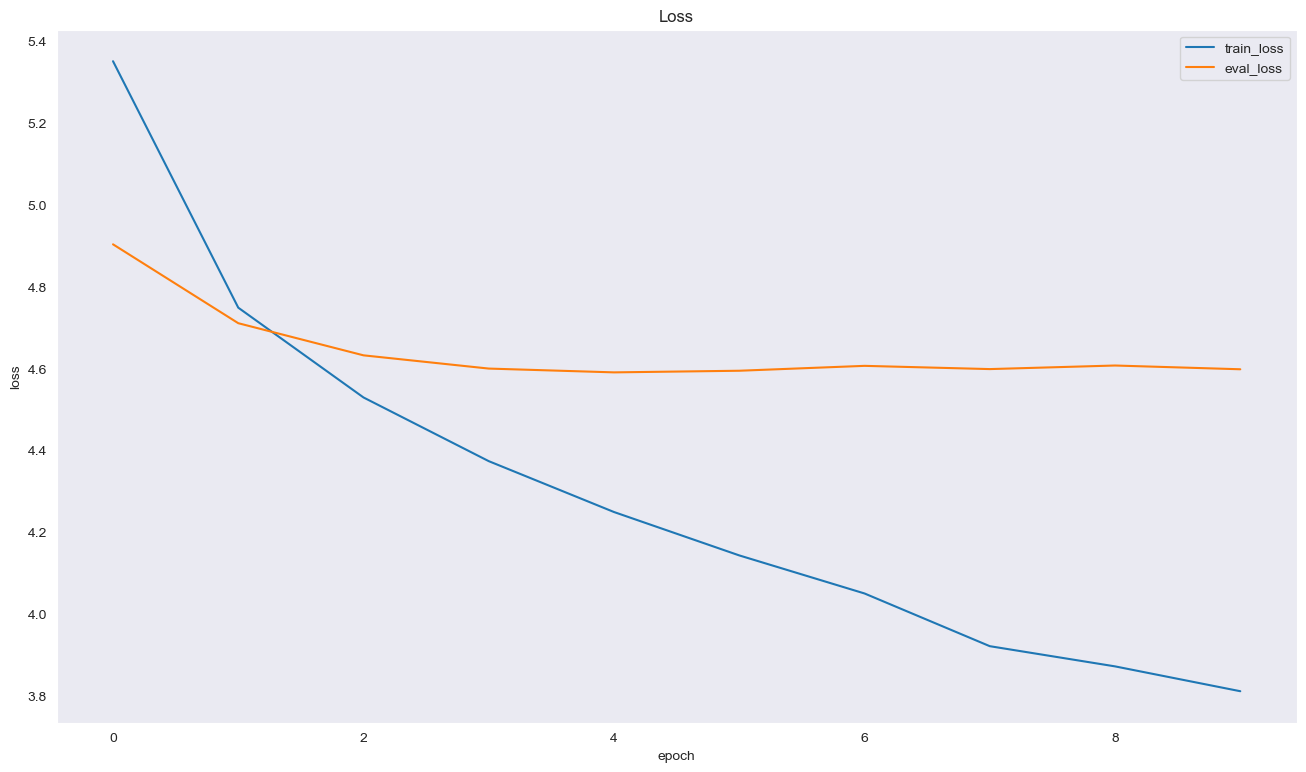

min eval loss: 4.5904801319807005 min eval perplexity: 99.04459713666867


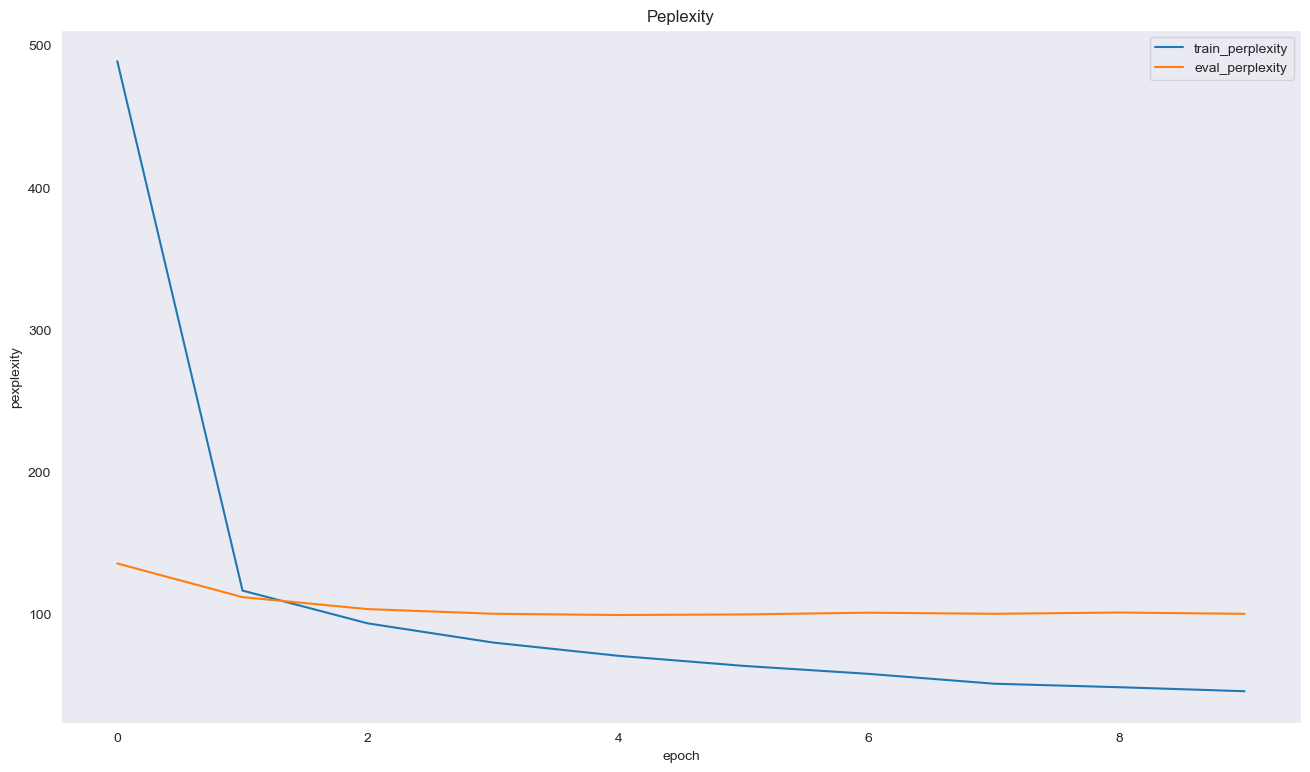

In [46]:
plot_results(result)

In [47]:
class Model4(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size=len(vocab)):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.1)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, vocab_size)

        self.dropout = nn.Dropout(0.1)
        self.non_lin = nn.Tanh()

    def forward(self, input_batch):
        x = self.embedding(input_batch)
        output, _ = self.rnn(x)

        output = self.dropout(self.non_lin(self.linear1(output)))

        result = self.linear2(output)

        return result

In [48]:
model = Model4(hidden_dim=256).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=1, verbose=True
)

In [49]:
result = train(model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler)

Epoch 0: 100%|██████████| 1243/1243 [01:15<00:00, 16.47it/s]


val_loss: 5.143972295981187 val_perplexity: 172.12618324084158


Epoch 1: 100%|██████████| 1243/1243 [01:13<00:00, 16.93it/s]


val_loss: 4.8550040905292215 val_perplexity: 128.97127694350021


Epoch 2: 100%|██████████| 1243/1243 [01:13<00:00, 16.94it/s]


val_loss: 4.731399569755945 val_perplexity: 114.000272163978


Epoch 3: 100%|██████████| 1243/1243 [01:13<00:00, 16.92it/s]


val_loss: 4.668871460816799 val_perplexity: 107.1098461151123


Epoch 4: 100%|██████████| 1243/1243 [01:15<00:00, 16.44it/s]


val_loss: 4.637035800860478 val_perplexity: 103.78521733406262


Epoch 5: 100%|██████████| 1243/1243 [01:16<00:00, 16.35it/s]


val_loss: 4.620834078544226 val_perplexity: 102.13863842303937


Epoch 6: 100%|██████████| 1243/1243 [01:15<00:00, 16.46it/s]


val_loss: 4.611085885610336 val_perplexity: 101.16561899429712


Epoch 7: 100%|██████████| 1243/1243 [01:13<00:00, 16.82it/s]


val_loss: 4.608804143392122 val_perplexity: 100.95678896781726


Epoch 8: 100%|██████████| 1243/1243 [01:13<00:00, 16.82it/s]


val_loss: 4.611689640925481 val_perplexity: 101.26895728478065


Epoch 9: 100%|██████████| 1243/1243 [01:13<00:00, 16.85it/s]


val_loss: 4.618633517852197 val_perplexity: 102.00319290161133


min train loss: 4.075591906941138 min train perplexity: 59.088108145605624


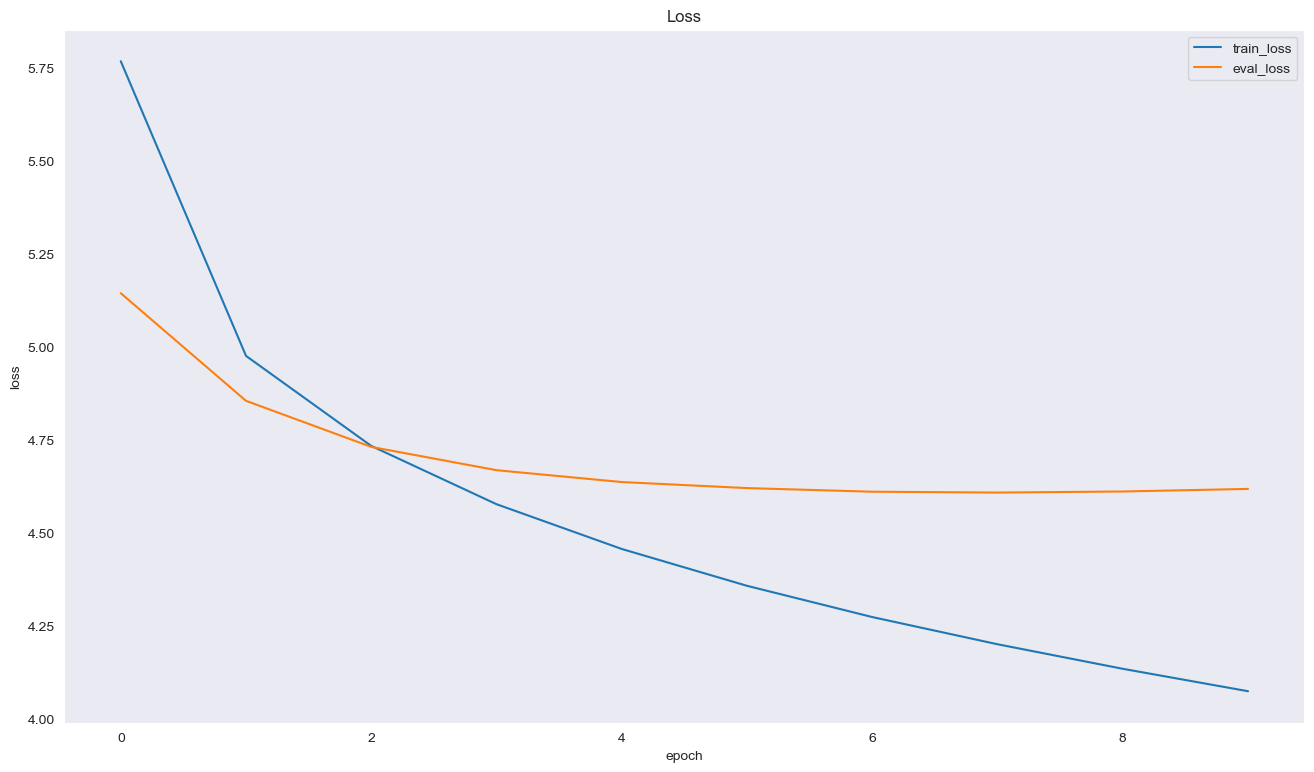

min eval loss: 4.608804143392122 min eval perplexity: 100.95678896781726


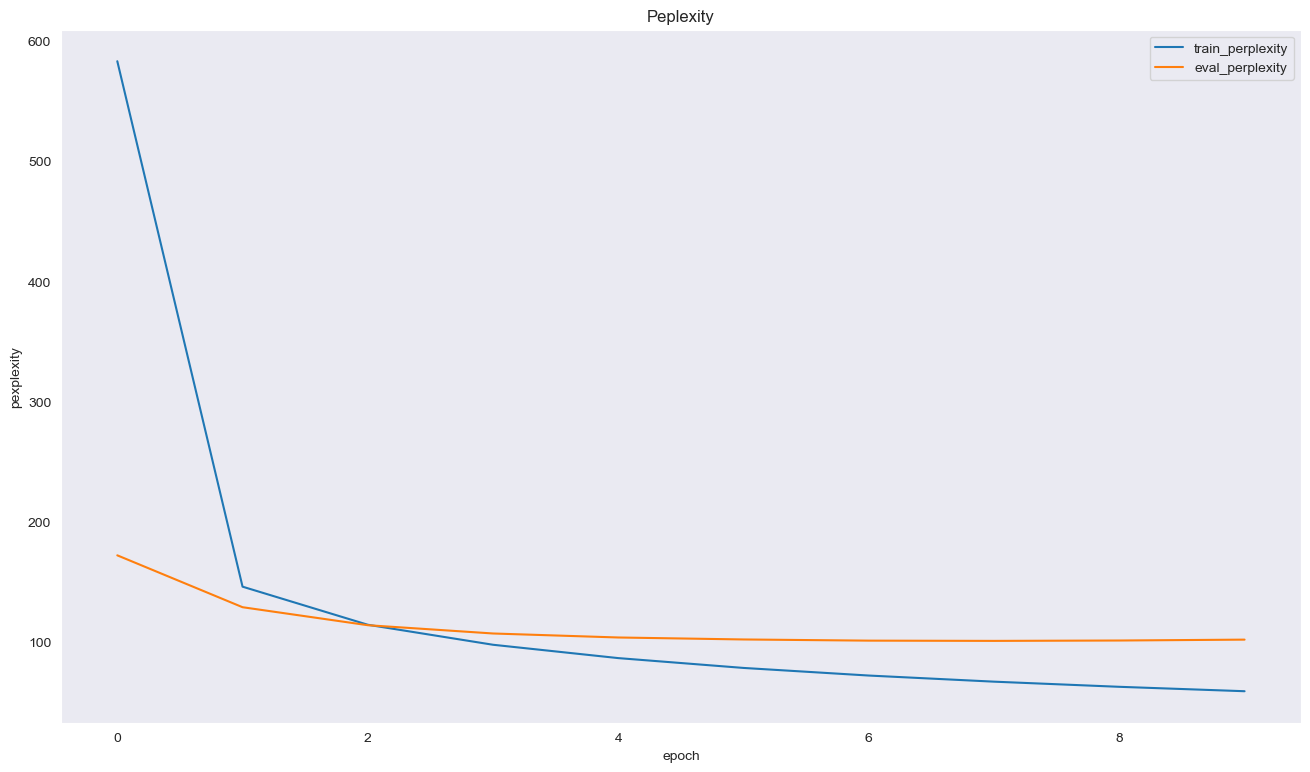

In [50]:
plot_results(result)

In [51]:
model = Model4(hidden_dim=512).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

In [52]:
result = train(model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler)

Epoch 0: 100%|██████████| 1243/1243 [01:49<00:00, 11.34it/s]


val_loss: 5.015570169840103 val_perplexity: 151.40745793856107


Epoch 1: 100%|██████████| 1243/1243 [01:50<00:00, 11.21it/s]


val_loss: 4.709531401976561 val_perplexity: 111.52886346670297


Epoch 2: 100%|██████████| 1243/1243 [01:50<00:00, 11.30it/s]


val_loss: 4.604174063755916 val_perplexity: 100.40367209605681


Epoch 3: 100%|██████████| 1243/1243 [01:48<00:00, 11.48it/s]


val_loss: 4.566635871544863 val_perplexity: 96.74262868441068


Epoch 4: 100%|██████████| 1243/1243 [01:49<00:00, 11.38it/s]


val_loss: 4.560664910536546 val_perplexity: 96.20076067019731


Epoch 5: 100%|██████████| 1243/1243 [01:49<00:00, 11.35it/s]


val_loss: 4.580342011573987 val_perplexity: 98.14177738091884


Epoch 6: 100%|██████████| 1243/1243 [01:47<00:00, 11.52it/s]


val_loss: 4.60512561370165 val_perplexity: 100.64806781670985


Epoch 7: 100%|██████████| 1243/1243 [01:46<00:00, 11.72it/s]


val_loss: 4.640181058492416 val_perplexity: 104.28458976745605


Epoch 8: 100%|██████████| 1243/1243 [01:47<00:00, 11.55it/s]


val_loss: 4.639438986778259 val_perplexity: 104.25198286007613


Epoch 9: 100%|██████████| 1243/1243 [01:49<00:00, 11.35it/s]


val_loss: 4.66285763337062 val_perplexity: 106.74707187750401


min train loss: 3.544125697541793 min train perplexity: 34.75523127113152


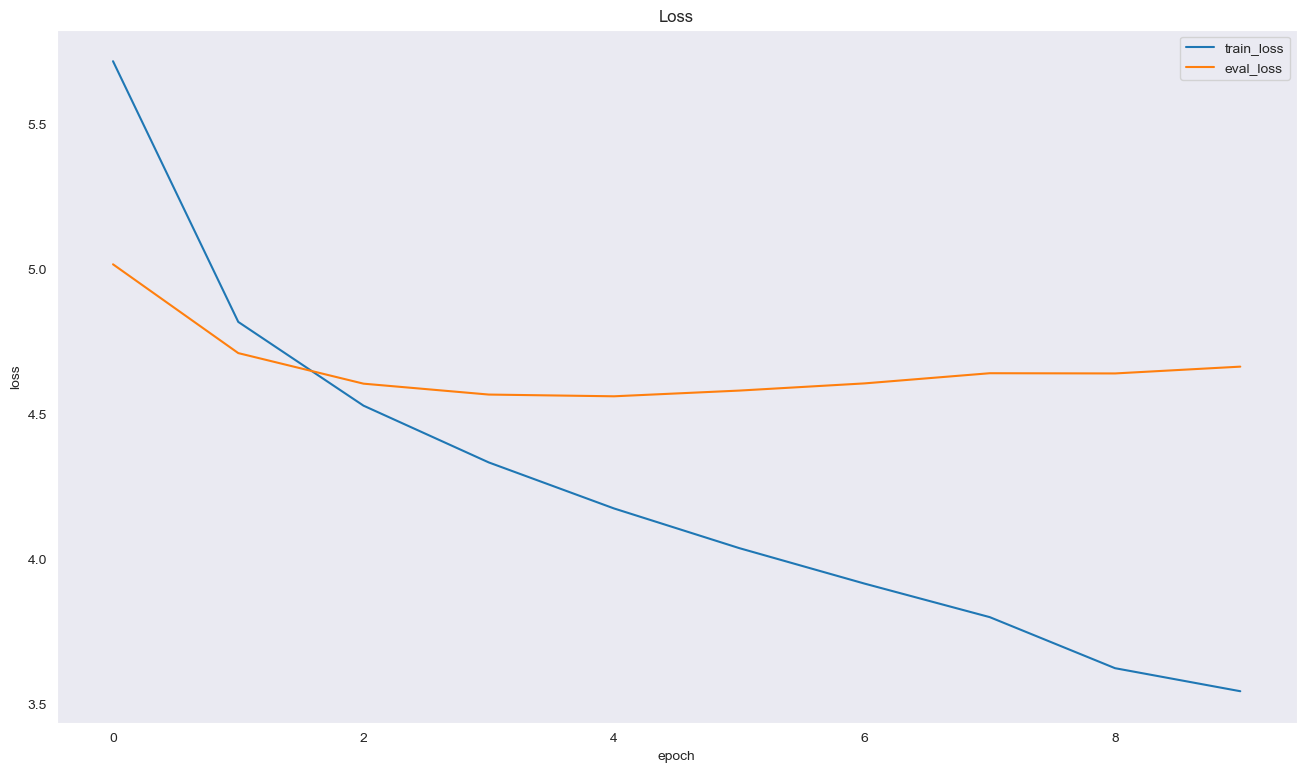

min eval loss: 4.560664910536546 min eval perplexity: 96.20076067019731


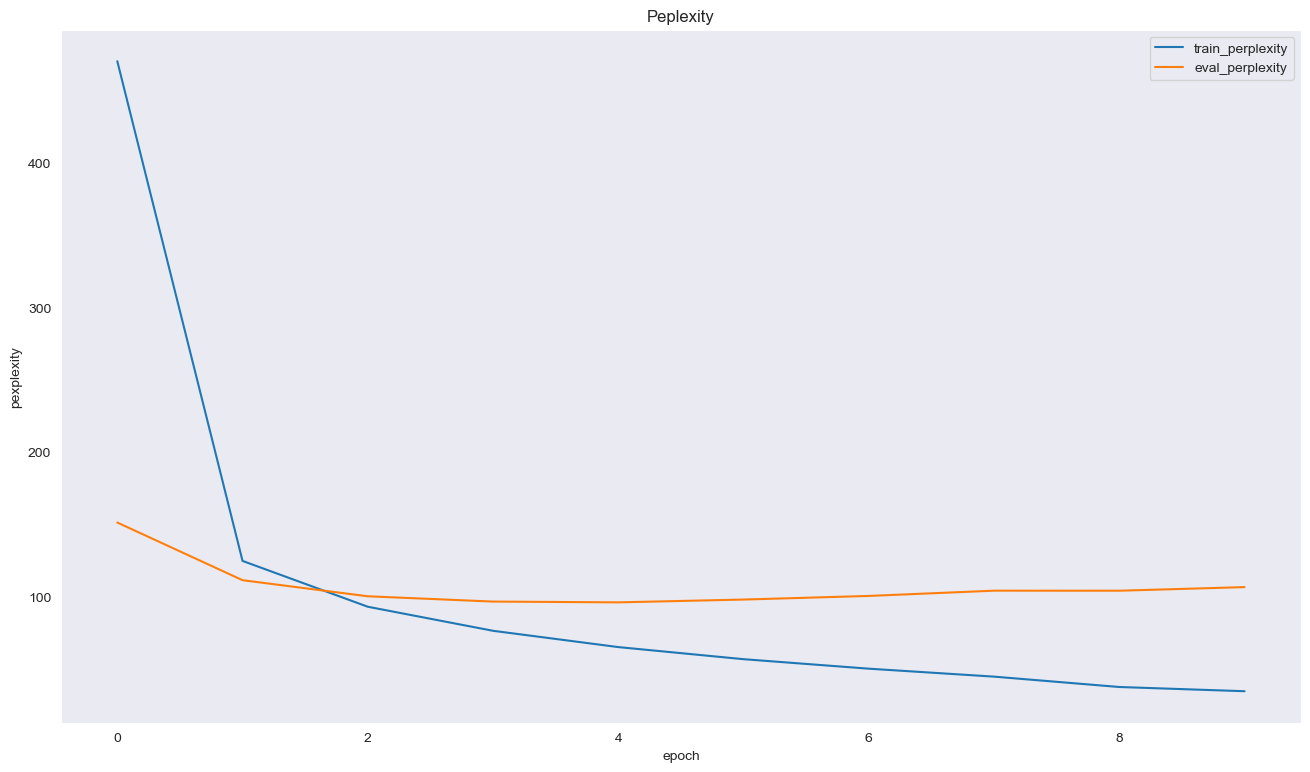

In [53]:
plot_results(result)

In [56]:
model = Model4(hidden_dim=512).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=1, verbose=True
)

In [57]:
result = train(model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler)

Epoch 0: 100%|██████████| 1243/1243 [01:51<00:00, 11.12it/s]


val_loss: 5.023118926928594 val_perplexity: 152.54021111512796


Epoch 1: 100%|██████████| 1243/1243 [01:51<00:00, 11.13it/s]


val_loss: 4.7244971348689155 val_perplexity: 113.21516178815793


Epoch 2: 100%|██████████| 1243/1243 [01:50<00:00, 11.21it/s]


val_loss: 4.616175981668325 val_perplexity: 101.61570416964017


Epoch 3: 100%|██████████| 1243/1243 [01:49<00:00, 11.38it/s]


val_loss: 4.572335649759341 val_perplexity: 97.29064696874374


Epoch 4: 100%|██████████| 1243/1243 [01:47<00:00, 11.52it/s]


val_loss: 4.562719189203703 val_perplexity: 96.39245385390062


Epoch 5: 100%|██████████| 1243/1243 [01:48<00:00, 11.42it/s]


val_loss: 4.569713461093413 val_perplexity: 97.09758729201097


Epoch 6: 100%|██████████| 1243/1243 [01:47<00:00, 11.52it/s]


val_loss: 4.5949918031692505 val_perplexity: 99.63024163857484


Epoch 7: 100%|██████████| 1243/1243 [01:45<00:00, 11.75it/s]


val_loss: 4.587217850562854 val_perplexity: 98.87522814824031


Epoch 8: 100%|██████████| 1243/1243 [01:50<00:00, 11.26it/s]


val_loss: 4.60767800685687 val_perplexity: 100.93708786597618


Epoch 9: 100%|██████████| 1243/1243 [01:48<00:00, 11.49it/s]


val_loss: 4.59855199777163 val_perplexity: 100.03586074633476


min train loss: 3.6059019320066765 min train perplexity: 37.001484090631656


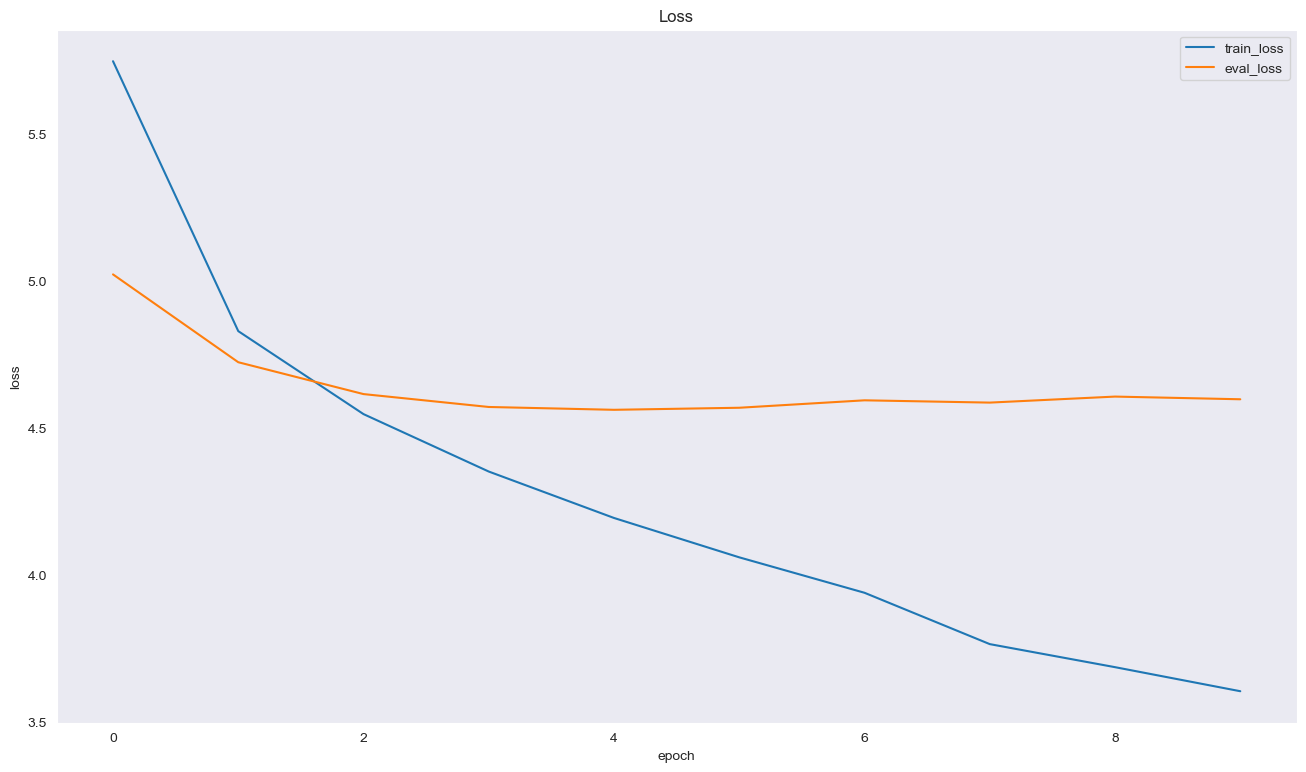

min eval loss: 4.562719189203703 min eval perplexity: 96.39245385390062


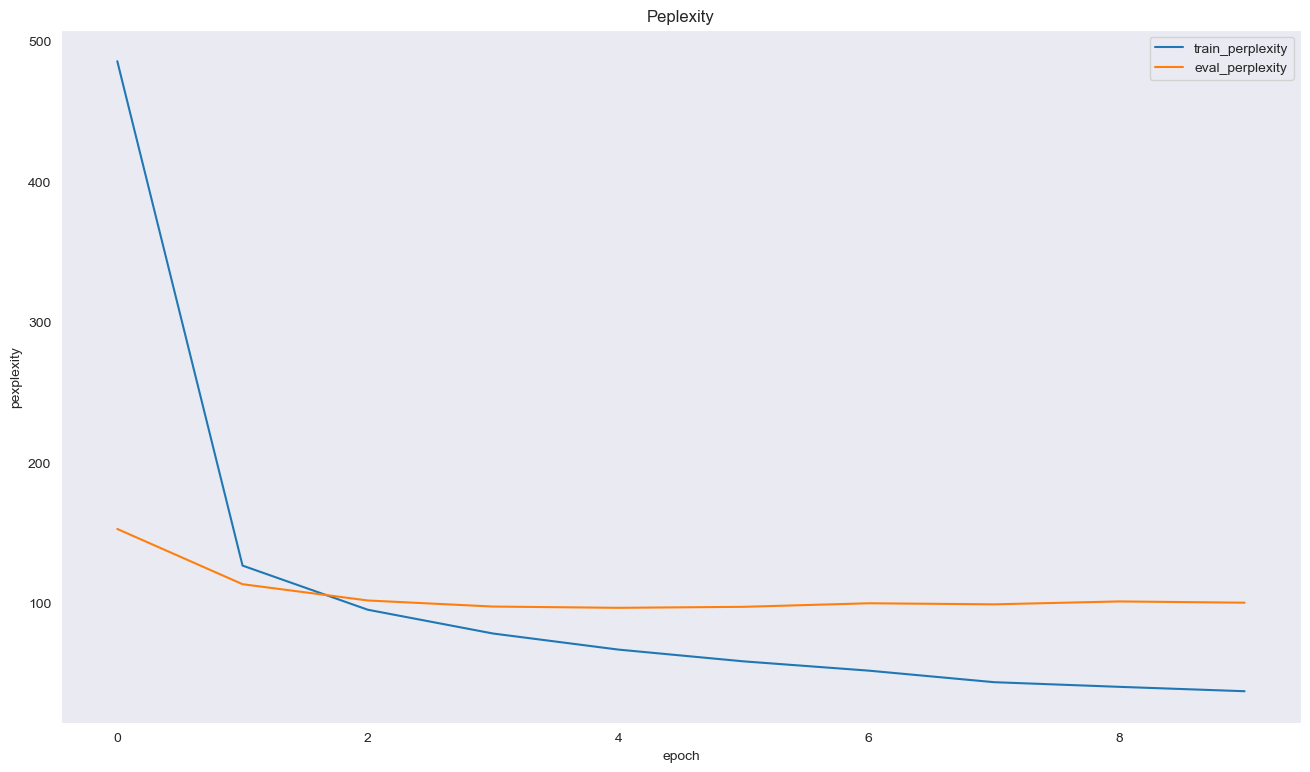

In [58]:
plot_results(result)

In [59]:
model = Model4(hidden_dim=1024).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=1, verbose=True
)

In [60]:
result = train(model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler)

Epoch 0: 100%|██████████| 1243/1243 [03:18<00:00,  6.26it/s]


val_loss: 4.72960076882289 val_perplexity: 113.77714117979392


Epoch 1: 100%|██████████| 1243/1243 [03:26<00:00,  6.01it/s]


val_loss: 4.543629612678137 val_perplexity: 94.50379914503831


Epoch 2: 100%|██████████| 1243/1243 [03:29<00:00,  5.92it/s]


val_loss: 4.519317364081358 val_perplexity: 92.28137055421487


Epoch 3: 100%|██████████| 1243/1243 [03:27<00:00,  5.98it/s]


val_loss: 4.556503106386233 val_perplexity: 95.83507122137608


Epoch 4: 100%|██████████| 1243/1243 [03:26<00:00,  6.02it/s]


val_loss: 4.648044644257961 val_perplexity: 105.12731376061073


Epoch 5: 100%|██████████| 1243/1243 [03:28<00:00,  5.95it/s]


val_loss: 4.7270032198001175 val_perplexity: 113.8681461138603


Epoch 6: 100%|██████████| 1243/1243 [03:21<00:00,  6.16it/s]


val_loss: 4.8292047671782665 val_perplexity: 126.25458668439816


Epoch 7: 100%|██████████| 1243/1243 [03:30<00:00,  5.92it/s]


val_loss: 4.89527010000669 val_perplexity: 134.99127216828174


Epoch 8: 100%|██████████| 1243/1243 [03:24<00:00,  6.08it/s]


val_loss: 4.969632359651419 val_perplexity: 145.5197077531081


Epoch 9: 100%|██████████| 1243/1243 [03:26<00:00,  6.02it/s]


val_loss: 4.999088250673735 val_perplexity: 149.94211309384076


min train loss: 2.739587849603961 min train perplexity: 15.65815630826083


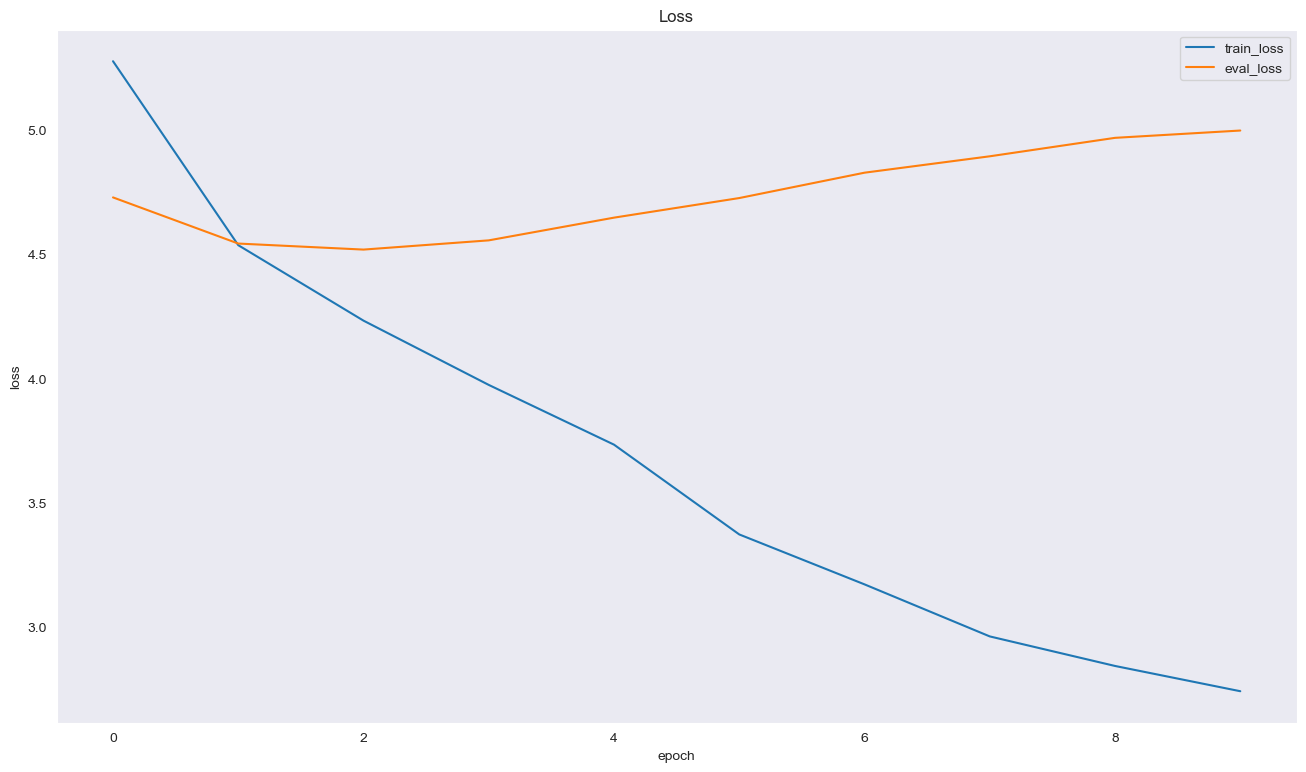

min eval loss: 4.519317364081358 min eval perplexity: 92.28137055421487


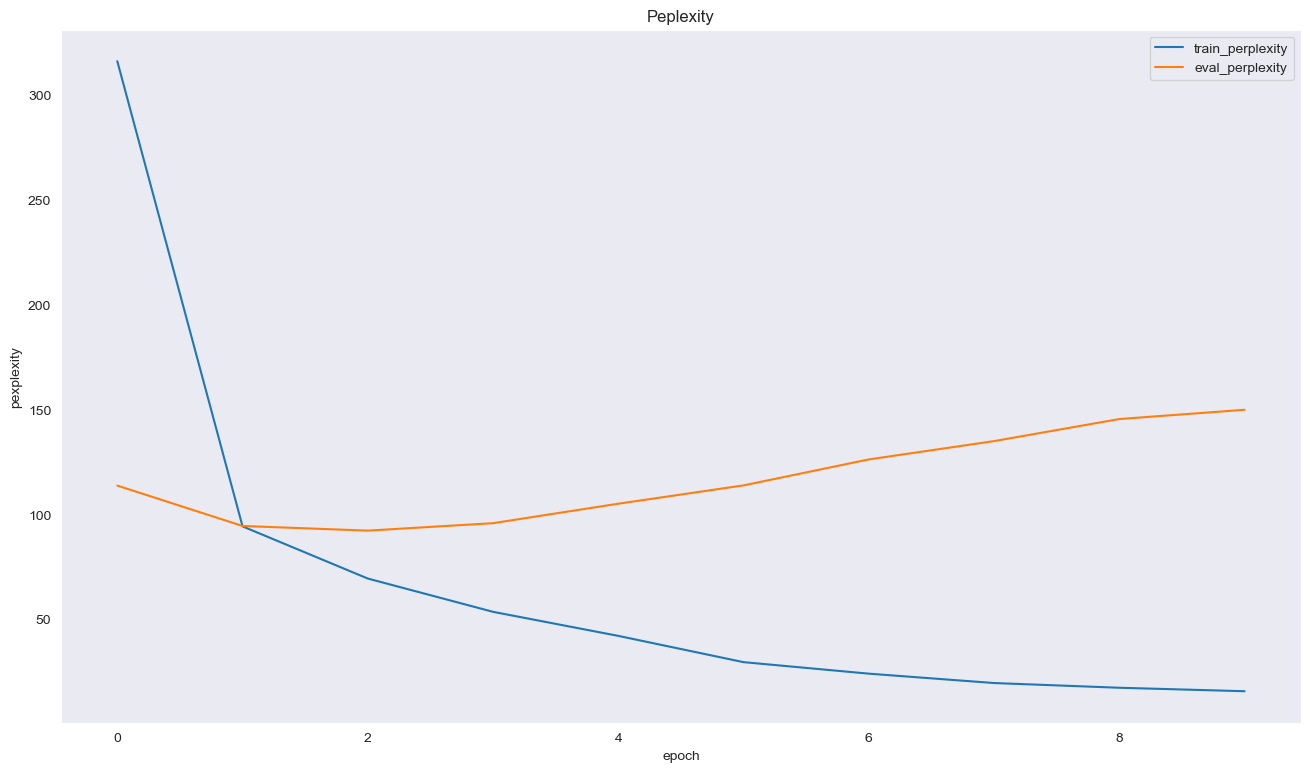

In [61]:
plot_results(result)

In [62]:
model = Model4(hidden_dim=1024).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.AdamW(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=1, verbose=True
)

c:\Users\knyze\miniforge3\envs\main_nn\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [63]:
result = train(model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler, epochs=3)

Epoch 0: 100%|██████████| 1243/1243 [03:40<00:00,  5.64it/s]


val_loss: 4.698630907596686 val_perplexity: 110.3161063072009


Epoch 1: 100%|██████████| 1243/1243 [03:28<00:00,  5.95it/s]


val_loss: 4.525381063803648 val_perplexity: 92.80833332355206


Epoch 2: 100%|██████████| 1243/1243 [03:34<00:00,  5.78it/s]


val_loss: 4.501927198507847 val_perplexity: 90.6923138056046


In [70]:
generate_sequence(model, 'this film so bad')

"<bos> this film so bad it 's bad . <eos> "